# Module 3 - Exercise 2: Model Architecture Experimentation

## Learning Objectives
- Handle mixed data types (numerical and categorical) in neural networks
- Implement and experiment with embedding layers for categorical features
- Compare different model architectures and their impact on performance
- Apply regularization techniques (dropout) to prevent overfitting
- Experiment with different activation functions
- Implement skip connections for improved gradient flow
- Systematically evaluate model changes on a test set

## Environment Setup

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Section 1: Dataset Preparation - Adult Income Dataset

We'll use the Adult Income dataset, which contains both numerical and categorical features. The task is to predict whether a person earns more than $50K per year.

In [14]:
# Load the Adult Income dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'marital-status', 'occupation', 'relationship', 'race', 'sex',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

# Load data
df = pd.read_csv(url, names=column_names, na_values=' ?', skipinitialspace=True)
df = df.dropna()  # Remove missing values for simplicity

# Select features for our model
numerical_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'marital-status', 'occupation', 'sex']

print(f"Dataset shape: {df.shape}")
print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")
print(f"\nTarget distribution:")
print(df['income'].value_counts(normalize=True))

Dataset shape: (32561, 15)
Numerical features: ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical features: ['workclass', 'marital-status', 'occupation', 'sex']

Target distribution:
income
<=50K    0.75919
>50K     0.24081
Name: proportion, dtype: float64


## Section 2: Data Preprocessing and Split

In [15]:
# Prepare features and target
X_num = df[numerical_features].values
X_cat = df[categorical_features]

# Encode categorical features
cat_encoders = {}
X_cat_encoded = []
cat_dims = {}  # Store dimensions for embeddings

for col in categorical_features:
    le = LabelEncoder()
    encoded = le.fit_transform(X_cat[col])
    cat_encoders[col] = le
    X_cat_encoded.append(encoded)
    cat_dims[col] = len(le.classes_)
    print(f"{col}: {cat_dims[col]} unique values")

X_cat_encoded = np.column_stack(X_cat_encoded)

# Encode target
y = (df['income'] == '>50K').astype(int).values

# Scale numerical features
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Create train/val/test split with fixed random state for reproducibility
X_num_train, X_num_temp, X_cat_train, X_cat_temp, y_train, y_temp = train_test_split(
    X_num_scaled, X_cat_encoded, y, test_size=0.3, random_state=42, stratify=y
)

X_num_val, X_num_test, X_cat_val, X_cat_test, y_val, y_test = train_test_split(
    X_num_temp, X_cat_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nTrain size: {len(y_train)}")
print(f"Validation size: {len(y_val)}")
print(f"Test size: {len(y_test)}")

# Convert to PyTorch tensors
X_num_train_t = torch.FloatTensor(X_num_train)
X_cat_train_t = torch.LongTensor(X_cat_train)
y_train_t = torch.FloatTensor(y_train)

X_num_val_t = torch.FloatTensor(X_num_val)
X_cat_val_t = torch.LongTensor(X_cat_val)
y_val_t = torch.FloatTensor(y_val)

X_num_test_t = torch.FloatTensor(X_num_test)
X_cat_test_t = torch.LongTensor(X_cat_test)
y_test_t = torch.FloatTensor(y_test)

# Create DataLoaders
batch_size = 256

train_dataset = TensorDataset(X_num_train_t, X_cat_train_t, y_train_t)
val_dataset = TensorDataset(X_num_val_t, X_cat_val_t, y_val_t)
test_dataset = TensorDataset(X_num_test_t, X_cat_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

workclass: 9 unique values
marital-status: 7 unique values
occupation: 15 unique values
sex: 2 unique values

Train size: 22792
Validation size: 4884
Test size: 4885


## Section 3: Baseline Model with Embeddings

Let's create a simple baseline model that handles both numerical and categorical features using embeddings.

In [16]:
class BaselineModel(nn.Module):
    def __init__(self, num_features, cat_dims, emb_dim=4, hidden_dim=64):
        super(BaselineModel, self).__init__()

        # Create embedding layers for each categorical feature
        self.embeddings = nn.ModuleList([
            nn.Embedding(dim, emb_dim) for dim in cat_dims.values()
        ])

        # Calculate total input dimension
        total_input_dim = num_features + len(cat_dims) * emb_dim

        # Simple feedforward network
        self.fc1 = nn.Linear(total_input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x_num, x_cat):
        # Process embeddings
        embeddings = []
        for i, emb_layer in enumerate(self.embeddings):
            embeddings.append(emb_layer(x_cat[:, i]))

        # Concatenate numerical features and embeddings
        x = torch.cat([x_num] + embeddings, dim=1)

        # Forward pass
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze()

# Initialize baseline model
baseline_model = BaselineModel(
    num_features=len(numerical_features),
    cat_dims=cat_dims,
    emb_dim=4,
    hidden_dim=64
).to(device)

print(f"Model parameters: {sum(p.numel() for p in baseline_model.parameters())}")

Model parameters: 1605


## Section 4: Training and Evaluation Functions

In [17]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for x_num, x_cat, y in loader:
        x_num, x_cat, y = x_num.to(device), x_cat.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x_num, x_cat)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct += (predicted == y).sum().item()
        total += y.size(0)

    return total_loss / len(loader), correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for x_num, x_cat, y in loader:
            x_num, x_cat, y = x_num.to(device), x_cat.to(device), y.to(device)

            outputs = model(x_num, x_cat)
            loss = criterion(outputs, y)

            total_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == y).sum().item()
            total += y.size(0)

    return total_loss / len(loader), correct / total

def train_model(model, train_loader, val_loader, epochs=30, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history

def plot_training_history(history, title="Training History"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['train_acc'], label='Train Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'{title} - Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

## Section 5: Baseline Model Training and Evaluation

Training Baseline Model...
Epoch 5/30 - Train Loss: 0.3231, Train Acc: 0.8483, Val Loss: 0.3175, Val Acc: 0.8554
Epoch 10/30 - Train Loss: 0.3141, Train Acc: 0.8533, Val Loss: 0.3100, Val Acc: 0.8561
Epoch 15/30 - Train Loss: 0.3079, Train Acc: 0.8549, Val Loss: 0.3098, Val Acc: 0.8595
Epoch 20/30 - Train Loss: 0.3066, Train Acc: 0.8567, Val Loss: 0.3089, Val Acc: 0.8593
Epoch 25/30 - Train Loss: 0.3041, Train Acc: 0.8574, Val Loss: 0.3071, Val Acc: 0.8597
Epoch 30/30 - Train Loss: 0.3041, Train Acc: 0.8581, Val Loss: 0.3078, Val Acc: 0.8589

Baseline Test Performance - Loss: 0.3073, Accuracy: 0.8579


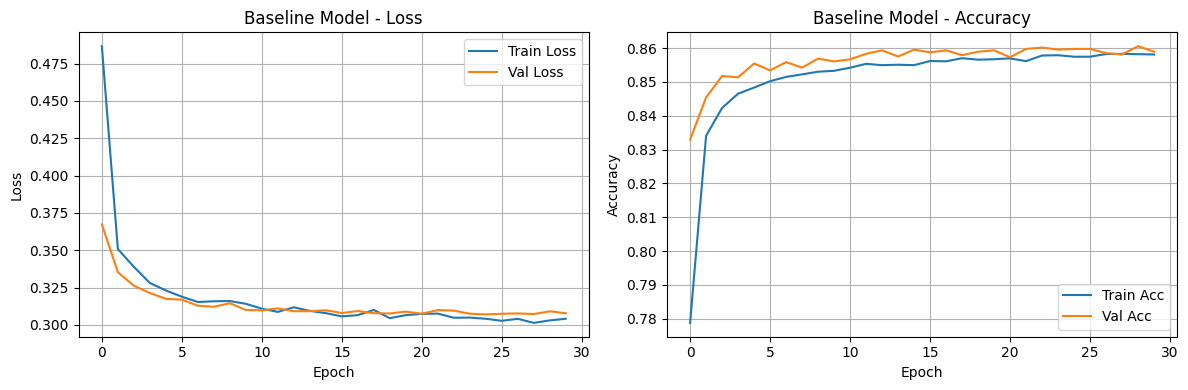

In [18]:
# Train baseline model
print("Training Baseline Model...")
baseline_history = train_model(baseline_model, train_loader, val_loader, epochs=30)

# Evaluate on test set
criterion = nn.BCELoss()
test_loss, test_acc = evaluate(baseline_model, test_loader, criterion, device)
print(f"\nBaseline Test Performance - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

# Plot training history
plot_training_history(baseline_history, "Baseline Model")

## Section 6: Experiment 1 - Deeper Architecture

Now let's experiment with a deeper architecture. Add more layers and experiment with different layer sizes.

**Task**: Create a model with at least 3 hidden layers with different sizes. Think about how the layer sizes should change (e.g., bottleneck, expanding, or constant).

In [25]:
class DeeperModel(nn.Module):
    def __init__(self, num_features, cat_dims, emb_dim=4):
        super(DeeperModel, self).__init__()

        # Embeddings (same as baseline)
        self.embeddings = nn.ModuleList([
            nn.Embedding(dim, emb_dim) for dim in cat_dims.values()
        ])

        total_input_dim = num_features + len(cat_dims) * emb_dim

        # TODO: Design a deeper architecture with at least 3 hidden layers
        # Consider layer sizes like: 128 -> 64 -> 32 (bottleneck)
        # or 64 -> 128 -> 64 (expanding) or 100 -> 100 -> 100 (constant)
        self.fc1 = nn.Linear(21,128)  # TODO: Replace with nn.Linear(...)
        self.fc2 = nn.Linear(128,64)  # TODO: Add more layers
        self.fc3 = nn.Linear(64,1)  # TODO: Add more layers
        self.fc_out = nn.ReLU()  # TODO: Output layer

    def forward(self, x_num, x_cat):
        # Process embeddings (same as baseline)
        embeddings = []
        for i, emb_layer in enumerate(self.embeddings):
            embeddings.append(emb_layer(x_cat[:, i]))

        x = torch.cat([x_num] + embeddings, dim=1)

        # TODO: Implement forward pass through your deeper architecture
        # Remember to apply activation functions between layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc_out(x))

        return x.squeeze()

# TODO: Initialize and train your deeper model
deeper_model = DeeperModel(256,cat_dims).to('cuda')  # TODO: Create model instance

# TODO: Train the model
deeper_history = train_model(deeper_model, train_loader, val_loader, epochs=30)

# TODO: Evaluate on test set and compare with baseline
test_loss, test_acc = evaluate(deeper_model, test_loader, criterion, device)
print(f"Deeper Model Test Performance - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

Epoch 5/30 - Train Loss: 0.6548, Train Acc: 0.8492, Val Loss: 0.6557, Val Acc: 0.8546
Epoch 10/30 - Train Loss: 0.6535, Train Acc: 0.8544, Val Loss: 0.6550, Val Acc: 0.8550
Epoch 15/30 - Train Loss: 0.6502, Train Acc: 0.8560, Val Loss: 0.6547, Val Acc: 0.8569
Epoch 20/30 - Train Loss: 0.6477, Train Acc: 0.8574, Val Loss: 0.6552, Val Acc: 0.8542
Epoch 25/30 - Train Loss: 0.6472, Train Acc: 0.8590, Val Loss: 0.6548, Val Acc: 0.8552
Epoch 30/30 - Train Loss: 0.6474, Train Acc: 0.8579, Val Loss: 0.6721, Val Acc: 0.8563
Deeper Model Test Performance - Loss: 0.6750, Accuracy: 0.8524


## Section 7: Experiment 2 - Adding Dropout

Dropout is a regularization technique that helps prevent overfitting. Add dropout layers to your model.

**Task**: Add dropout layers with different dropout rates (e.g., 0.2, 0.3, 0.5) and observe the effect on training and validation performance.

In [39]:
class ModelWithDropout(nn.Module):
    def __init__(self, num_features, cat_dims, emb_dim=4, dropout_rate=0.3):
        super(ModelWithDropout, self).__init__()

        self.embeddings = nn.ModuleList([
            nn.Embedding(dim, emb_dim) for dim in cat_dims.values()
        ])

        total_input_dim = num_features + len(cat_dims) * emb_dim

        # TODO: Build architecture with dropout layers
        # Hint: Use nn.Dropout(dropout_rate) between layers
        self.fc1 = nn.Linear(total_input_dim, 128)
        self.dropout1 = nn.Dropout(dropout_rate)  # TODO: Add dropout layer
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 =  nn.Dropout(dropout_rate)    # TODO: Add dropout layer
        self.fc3 = nn.Linear(64, 32)
        self.dropout3 =  nn.Dropout(dropout_rate)    # TODO: Add dropout layer
        self.fc_out = nn.Linear(32, 1)

    def forward(self, x_num, x_cat):
        embeddings = []
        for i, emb_layer in enumerate(self.embeddings):
            embeddings.append(emb_layer(x_cat[:, i]))

        x = torch.cat([x_num] + embeddings, dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.fc_out(x)
        # TODO: Implement forward pass with dropout
        # Remember: dropout is only applied during training
        # x = F.relu(self.fc1(x))
        # x = self.dropout1(x)  # Apply dropout
        # ...

        return x.squeeze()

# TODO: Experiment with different dropout rates
dropout_rates = [0.2, 0.3, 0.5]
dropout_results = {}

for rate in dropout_rates:
    print(f"\nTraining with dropout rate: {rate}")
    # TODO: Create model with specific dropout rate
    model = ModelWithDropout(128,cat_dims)
    # TODO: Train model
    dropout_history = train_model(model, train_loader, val_loader, epochs=30)
    # TODO: Evaluate on test set
    # TODO: Store results in dropout_results dictionary
    pass

# TODO: Compare results and identify best dropout rate


Training with dropout rate: 0.2


AcceleratorError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Section 8: Experiment 3 - Different Activation Functions

Different activation functions can significantly impact model performance. Let's experiment with various activation functions.

**Task**: Replace ReLU with other activation functions (LeakyReLU, ELU, GELU, Swish/SiLU) and compare their effects.

In [ ]:
class ModelWithDifferentActivations(nn.Module):
    def __init__(self, num_features, cat_dims, emb_dim=4, activation='relu'):
        super(ModelWithDifferentActivations, self).__init__()

        self.embeddings = nn.ModuleList([
            nn.Embedding(dim, emb_dim) for dim in cat_dims.values()
        ])

        total_input_dim = num_features + len(cat_dims) * emb_dim

        self.fc1 = nn.Linear(total_input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc_out = nn.Linear(32, 1)

        # TODO: Set activation function based on parameter
        self.activation = None
        if activation == 'relu':
            self.activation = F.relu
        elif activation == 'leaky_relu':
            # TODO: Set LeakyReLU (hint: use lambda x: F.leaky_relu(x, 0.01))
            pass
        elif activation == 'elu':
            # TODO: Set ELU
            pass
        elif activation == 'gelu':
            # TODO: Set GELU
            pass
        elif activation == 'silu':
            # TODO: Set SiLU/Swish
            pass

    def forward(self, x_num, x_cat):
        embeddings = []
        for i, emb_layer in enumerate(self.embeddings):
            embeddings.append(emb_layer(x_cat[:, i]))

        x = torch.cat([x_num] + embeddings, dim=1)

        # TODO: Use self.activation in forward pass
        # x = self.activation(self.fc1(x))
        # ...

        return x.squeeze()

# TODO: Test different activation functions
activations = ['relu', 'leaky_relu', 'elu', 'gelu', 'silu']
activation_results = {}

for activation in activations:
    print(f"\nTraining with {activation} activation")
    # TODO: Create model with specific activation
    # TODO: Train model
    # TODO: Evaluate on test set
    # TODO: Store results
    pass

## Section 9: Experiment 4 - Embedding Size Variation

The embedding dimension for categorical features can impact model capacity and performance.

**Task**: Experiment with different embedding sizes and observe their impact. Consider using different embedding sizes for different categorical features based on their cardinality.

In [ ]:
class ModelWithVariableEmbeddings(nn.Module):
    def __init__(self, num_features, cat_dims, emb_strategy='fixed'):
        super(ModelWithVariableEmbeddings, self).__init__()

        # TODO: Implement different embedding strategies
        # Strategy 1: 'fixed' - use same embedding size for all (e.g., 4)
        # Strategy 2: 'proportional' - embedding size proportional to sqrt(cardinality)
        # Strategy 3: 'custom' - manually set different sizes

        self.embeddings = nn.ModuleList()
        total_emb_dim = 0

        if emb_strategy == 'fixed':
            emb_dim = 4
            for dim in cat_dims.values():
                self.embeddings.append(nn.Embedding(dim, emb_dim))
                total_emb_dim += emb_dim
        elif emb_strategy == 'proportional':
            # TODO: Implement proportional strategy
            # Hint: emb_dim = min(50, int(np.sqrt(dim) * 2))
            pass
        elif emb_strategy == 'custom':
            # TODO: Implement custom strategy
            # Example: small features get 2, medium get 4, large get 8
            pass

        total_input_dim = num_features + total_emb_dim

        self.fc1 = nn.Linear(total_input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc_out = nn.Linear(32, 1)

    def forward(self, x_num, x_cat):
        embeddings = []
        for i, emb_layer in enumerate(self.embeddings):
            embeddings.append(emb_layer(x_cat[:, i]))

        x = torch.cat([x_num] + embeddings, dim=1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc_out(x))

        return x.squeeze()

# TODO: Test different embedding strategies
embedding_strategies = ['fixed', 'proportional', 'custom']
embedding_results = {}

for strategy in embedding_strategies:
    print(f"\nTraining with {strategy} embedding strategy")
    # TODO: Create model with specific strategy
    # TODO: Train model
    # TODO: Evaluate on test set
    # TODO: Store results
    pass

## Section 10: Experiment 5 - Skip Connections

Skip connections (residual connections) can help with gradient flow and enable training of deeper networks.

**Task**: Implement a model with skip connections. Think about where to place them and how to handle dimension mismatches.

In [ ]:
class ModelWithSkipConnections(nn.Module):
    def __init__(self, num_features, cat_dims, emb_dim=4):
        super(ModelWithSkipConnections, self).__init__()

        self.embeddings = nn.ModuleList([
            nn.Embedding(dim, emb_dim) for dim in cat_dims.values()
        ])

        total_input_dim = num_features + len(cat_dims) * emb_dim

        # Design layers with matching dimensions for skip connections
        self.fc1 = nn.Linear(total_input_dim, 128)
        self.fc2 = nn.Linear(128, 128)  # Same dimension for skip
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 64)   # Same dimension for skip
        self.fc_out = nn.Linear(64, 1)

        # TODO: Add projection layers for dimension matching if needed
        # self.proj1 = nn.Linear(total_input_dim, 128)  # For input skip

    def forward(self, x_num, x_cat):
        embeddings = []
        for i, emb_layer in enumerate(self.embeddings):
            embeddings.append(emb_layer(x_cat[:, i]))

        x = torch.cat([x_num] + embeddings, dim=1)

        # TODO: Implement forward pass with skip connections
        # Example pattern:
        # identity = x
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = x + identity  # Skip connection (need matching dimensions!)

        # Hint: You can use different skip patterns:
        # 1. Skip every 2 layers
        # 2. Dense connections (skip to multiple later layers)
        # 3. Skip from input to middle layers

        return x.squeeze()

# TODO: Create and train model with skip connections
skip_model = None  # TODO: Initialize model

# TODO: Train the model
# skip_history = train_model(skip_model, train_loader, val_loader, epochs=30)

# TODO: Evaluate on test set
# test_loss, test_acc = evaluate(skip_model, test_loader, criterion, device)
# print(f"Skip Connection Model Test Performance - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

## Section 11: Final Comparison and Analysis

Compare all your experimental results and draw conclusions about which architectural choices work best for this dataset.

**Task**: Create a summary table comparing all models and visualize the results.

In [ ]:
# TODO: Create a comparison table of all models
results_summary = {
    'Model': ['Baseline'],
    'Test Accuracy': [test_acc],  # From baseline model
    'Parameters': [sum(p.numel() for p in baseline_model.parameters())],
    'Best Val Accuracy': [max(baseline_history['val_acc'])]
}

# TODO: Add results from all your experiments
# results_summary['Model'].append('Deeper Model')
# results_summary['Test Accuracy'].append(...)
# ...

# Create DataFrame for nice display
# results_df = pd.DataFrame(results_summary)
# print(results_df.to_string())

# TODO: Create a bar plot comparing test accuracies
# plt.figure(figsize=(10, 6))
# plt.bar(results_summary['Model'], results_summary['Test Accuracy'])
# plt.xlabel('Model')
# plt.ylabel('Test Accuracy')
# plt.title('Model Performance Comparison')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

## Reflection Questions

After completing all experiments, consider these questions:

1. **Depth vs Width**: Did deeper models perform better than the baseline? What might be the trade-offs?

2. **Regularization**: How did dropout affect the gap between training and validation performance? What dropout rate worked best?

3. **Activation Functions**: Which activation function gave the best results? Why might certain activations work better for this dataset?

4. **Embeddings**: How did embedding size affect model performance? Is there a relationship between categorical feature cardinality and optimal embedding size?

5. **Skip Connections**: Did skip connections improve performance? In what scenarios might they be most beneficial?

6. **Overfitting**: Which techniques were most effective at reducing overfitting?

7. **Computational Cost**: How do the different architectural choices affect training time and memory usage?

In [ ]:
# TODO: Write your observations and conclusions here
observations = """
Key findings from experiments:
1.
2.
3.

Best performing configuration:
- Architecture:
- Activation:
- Dropout rate:
- Embedding strategy:
- Test accuracy:
"""

print(observations)